In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

from scipy import optimize

In [2]:
# Plotting style
default_cmap = "viridis"
figure_size  = 10, 5
font_size    = 16

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size
plt.rcParams[  "image.cmap"   ] =   default_cmap

plt.style.use(plt.style.available[10])

#set number of bins
nbins = 100

# 1. Import data

In [3]:
typo='Cs'
df = pd.HDFStore(f'corrections_6206_{typo}.h5')['/edf']

In [4]:
df.head()

,event,peak,loc,nslices,nhits,noqslices,noqhits,time,s1e,t0,...,x0,y0,z0,q0,e0,x,y,z,q,e
0,416,0,0,17,259,2,2706,1531471725062,142.078461,596.150378,...,-49.071080,-8.452012,61.065285,9231.001953,188439.78125,-48.798102,-8.389482,61.080067,9218.973028,164422.266338
1,638,0,0,25,293,4,2217,1531471729123,141.422714,494.007093,...,-138.894033,10.033711,165.153809,7902.346680,153924.96875,-138.672047,10.369649,165.194040,8656.621752,156114.460929
2,1047,0,0,22,299,4,2606,1531471737578,156.287827,519.870817,...,-5.123952,-20.835895,138.134109,9009.829102,180730.65625,-5.268191,-20.906321,138.140157,9402.072288,162037.707532
3,1055,0,0,24,159,7,733,1531471737617,195.207336,454.107072,...,-25.106869,81.592038,208.602814,3590.298340,74971.40625,-25.204429,81.609237,208.634541,4065.205362,74622.343744
4,1055,1,0,14,163,4,771,1531471737617,195.207336,454.107072,...,-68.818702,47.199135,246.855606,4272.459473,84634.53125,-68.848786,47.206998,246.853478,4738.999676,82745.972983


In [5]:
df.tail()

,event,peak,loc,nslices,nhits,noqslices,noqhits,time,s1e,t0,...,x0,y0,z0,q0,e0,x,y,z,q,e
143,13466522,0,420,31,337,4,2003,1531736543291,156.389694,381.402626,...,-19.125115,106.212116,280.354523,7410.335938,152215.500000,-19.039809,106.383569,280.368223,8970.983866,164577.758707
144,13466526,0,420,7,18,3,37,1531736543341,131.205750,592.309714,...,68.331717,-69.684743,59.694729,303.424255,7606.020020,68.284369,-69.695856,59.695132,316.239723,7111.394048
145,13466526,1,420,37,302,4,2103,1531736543341,131.205750,592.309714,...,99.675657,-105.639440,126.576302,7671.123535,144663.000000,99.879949,-105.704038,126.568776,8366.606349,152279.555644
146,13466644,0,420,27,271,4,1655,1531736545670,136.724075,571.637671,...,-76.752678,95.610381,88.702217,6835.383789,134282.421875,-76.789222,95.675753,88.713214,7027.507289,133200.057881
147,13466644,1,420,9,50,3,128,1531736545670,136.724075,571.637671,...,-129.786507,47.938841,125.035904,1196.625977,25848.595703,-129.837780,47.856987,125.036652,1326.956881,26321.080961


# 2. ENERGY

## 2.1 Overview

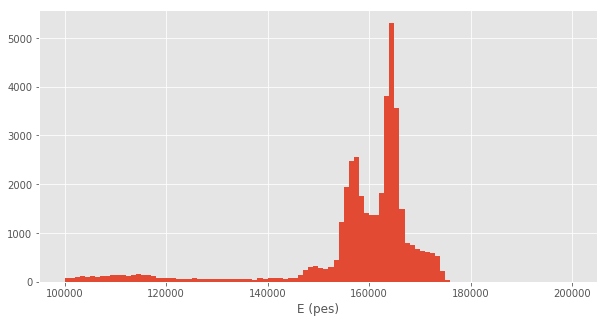

In [6]:
Emax = 200e3
Emin = 100e3

df['e'].hist(bins=nbins, range = (Emin, Emax));
plt.xlabel('E (pes)', fontsize=12);

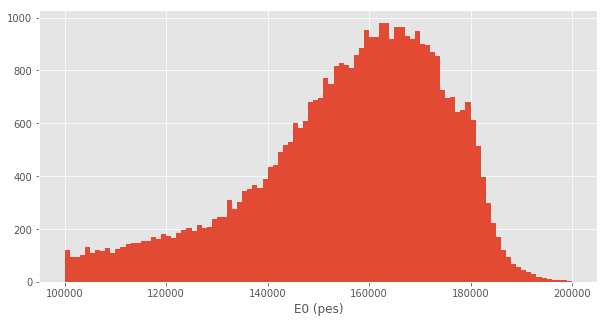

In [7]:
df['e0'].hist(bins=nbins, range = (Emin, Emax));
plt.xlabel('E0 (pes)', fontsize=12);

/home/gonzalo/anaconda3/envs/IC-3.7-2018-10-20/lib/python3.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gonzalo/anaconda3/envs/IC-3.7-2018-10-20/lib/python3.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


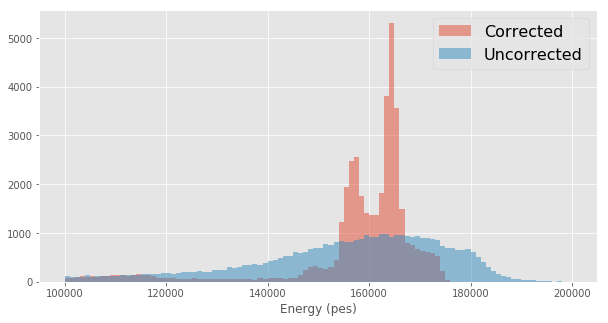

In [8]:
plt.hist(df['e'] , bins = nbins, range=(Emin, Emax), alpha=.5, label='Corrected' );
plt.hist(df['e0'], bins = nbins, range=(Emin, Emax), alpha=.5, label='Uncorrected' );
plt.legend(fontsize = 16);
plt.xlabel('Energy (pes)', fontsize=12);

## 2.2. Select region

In [9]:
Emax = 170e3
Emin = 160e3

In [10]:
edf = df[(df.e<Emax) & (df.e>Emin)]

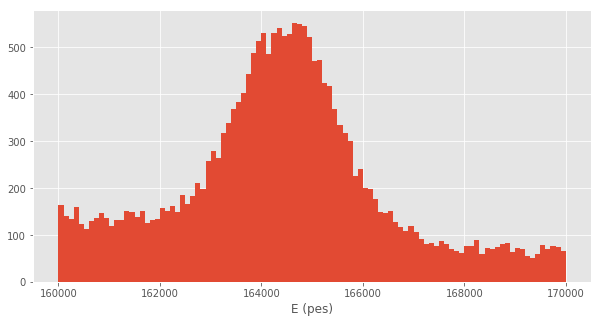

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

ydata, xdata, __ = ax.hist(edf['e'], bins=nbins, range = (Emin,Emax));
plt.xlabel('E (pes)', fontsize=12);

## 2.3. Fitting photopeak

We perform a gaussian fit for the photopeak and assume a linear fit for background

$$F(E) = A e^{-(E-E_{ph})^2/2\sigma^2} + m(E-E_{min}) + c$$

In [12]:
def F(E, Eph, sig, A, m, c):
    return A * np.e**(-(E-Eph)**2/(2*sig**2)) + m*(E-Emin) + c

def chisq(F, popt, xdata, ydata):
    return np.sum((F(xdata, *popt)-ydata)**2/((len(xdata)-len(popt))*ydata))

In [13]:
xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

guess = [np.mean(edf['e']), np.std(edf['e']), np.max(ydata), -1, np.mean(ydata)]
popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata))

Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]

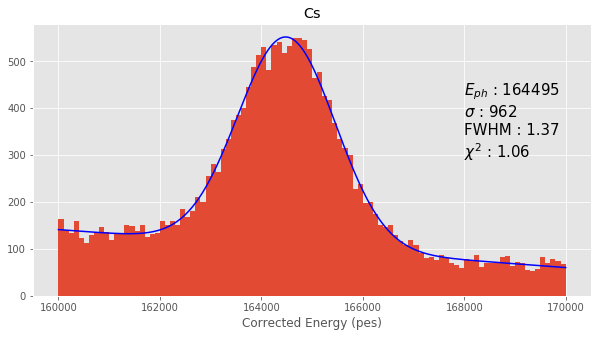

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(edf['e'], bins=nbins);
E = np.linspace(Emin, Emax, 2*nbins);
ax.plot(E, F(E, *popt), color = 'b');

t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2)) + 
     "\n" + r"$\chi^2$ : {}".format(round(chisq(F, popt, xdata, ydata),2))) 

ax.text(168000, 300, s = t, fontsize = 15);
ax.set_xlabel('Corrected Energy (pes)');
ax.set_title('{}'.format(typo));

In [15]:
print('Extrapolated FWHM:',sig/Eph * 235 * (662/2458)**.5)

Extrapolated FWHM: 0.71351988963823


## 2.4. Searching correlations

### 2.4.1. Corrected Energy correlations (E vs All variables)

In [16]:
var = edf.keys()
var = var[3:len(var)]
var

Index(['nslices', 'nhits', 'noqslices', 'noqhits', 'time', 's1e', 't0', 'rmax',
       'zmin', 'zmax', 'x0', 'y0', 'z0', 'q0', 'e0', 'x', 'y', 'z', 'q', 'e'],
      dtype='object')

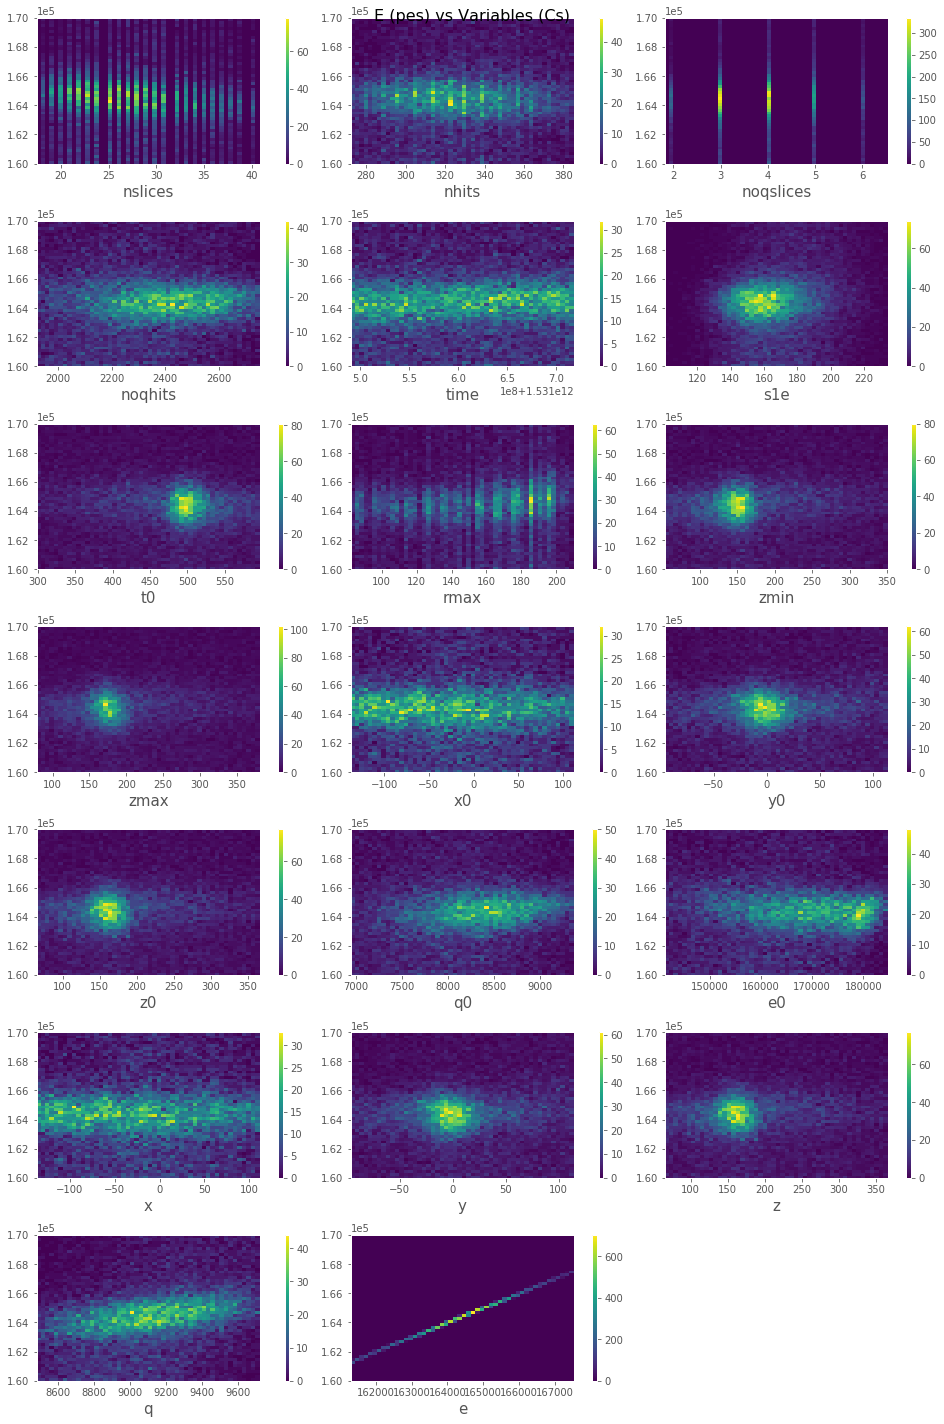

In [17]:
fig_e = plt.figure(figsize =[13, 20], constrained_layout=True);

gs_e = gridspec.GridSpec(round(len(var)/3+.5), 3, figure=fig_e);

i=0
for v in var:
    axes    = f'ax_e{v}   = fig_e.add_subplot(gs_e[{i}])'
    exec(axes)
    hist       = (f'hist_e{v} = ax_e{v}.hist2d(edf["{v}"], edf["e"] ,bins=.5*nbins,' + 
                  f'range=((np.mean(edf["{v}"])-1.5*np.std(edf["{v}"]), np.mean(edf["{v}"])+1.5*np.std(edf["{v}"])), (Emin, Emax)))')
    exec(hist)
    labels     = (f'ax_e{v}.set_xlabel("{v}", fontsize=15) \n'+
                  f'ax_e{v}.ticklabel_format(style="sci", axis="y", scilimits=(0,0))')
    exec(labels)
    #cbars      = f'cbar_e{v} = fig_e.colorbar(hist_e{v}[3], ax = ax_e{v})'
    #exec(cbars)
    i+=1
for v in var:
    cbars      = f'cbar_e{v} = fig_e.colorbar(hist_e{v}[3], ax = ax_e{v})'
    exec(cbars)
    fig_e.suptitle(f'E (pes) vs Variables ({typo})', fontsize=16);

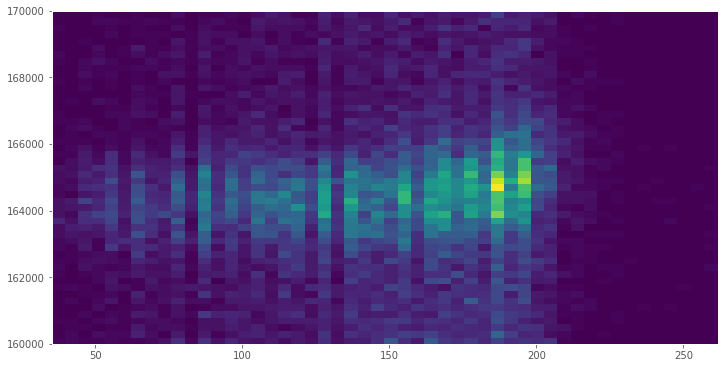

In [18]:
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0])

ax.hist2d(edf['rmax'], edf['e'], bins=.5*nbins);

### 2.4.2 E vs Number of Slices

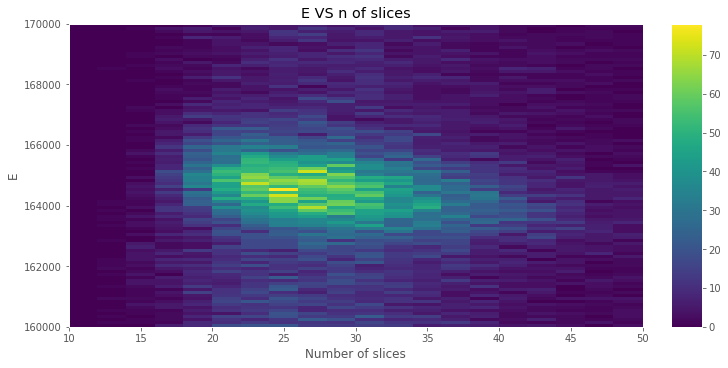

In [19]:
fig_enslices = plt.figure(constrained_layout=True)

gs_enslices = gridspec.GridSpec(1, 1, figure=fig_enslices)

ax_enslices = fig_enslices.add_subplot(gs_enslices[0, 0])
hist_enslices = ax_enslices.hist2d(edf['nslices'], edf['e'] , bins=[.2*nbins, nbins], range=((10, 50),(Emin, Emax)));
ax_enslices.set_xlabel('Number of slices');
ax_enslices.set_ylabel('E');
ax_enslices.set_title('E VS n of slices');
cbar_enslices = fig_enslices.colorbar(hist_enslices[3], ax = ax_enslices)

In [20]:
## Profile construction
cut    = 100 #cut for the number of entries in each slice
n_merg = 5   #size of the group of slices to merge

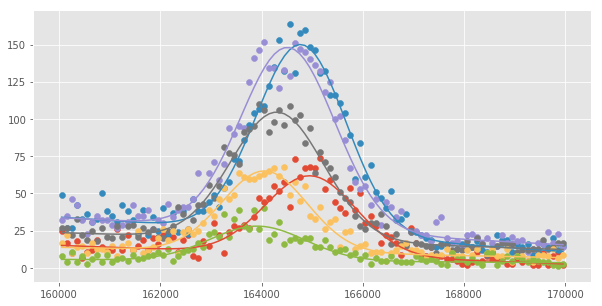

In [21]:
nslices_raw = np.unique(edf['nslices'])

#Cut in number of slices
nslices = []
for nsl in nslices_raw:
    if len(edf[edf.nslices == nsl])<cut:
        continue
    else: nslices.append(nsl)
nslices = np.array(nslices)

nslices_merged = np.array([nslices[n_merg*i:n_merg*(i+1)] for i in range(0, int(len(nslices)/n_merg))])

profile = pd.DataFrame(columns=['nslices', 'Eph', 'sig', 'chisq'])
for nslices in nslices_merged:
    cdf = edf[(edf.nslices >= nslices[0]) & ((edf.nslices <= nslices[-1]))]
    
    #Fitting
    ydata, xdata = np.histogram(cdf['e'], bins=nbins, range = (Emin,Emax))
    xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

    guess = [np.mean(cdf['e']), np.std(cdf['e']), np.max(ydata), -1, np.mean(ydata)]
    popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata))
    chi = chisq(F, popt, xdata, ydata)
    
    Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]
    
    nsl = np.sum(nslices)/len(nslices)
    profile = profile.append({'nslices': nsl, 'Eph': Eph, 'sig': sig, 'chisq': chi}, ignore_index=True)
    
    plt.scatter(xdata, ydata)
    plt.plot(xdata, F(xdata, *popt))

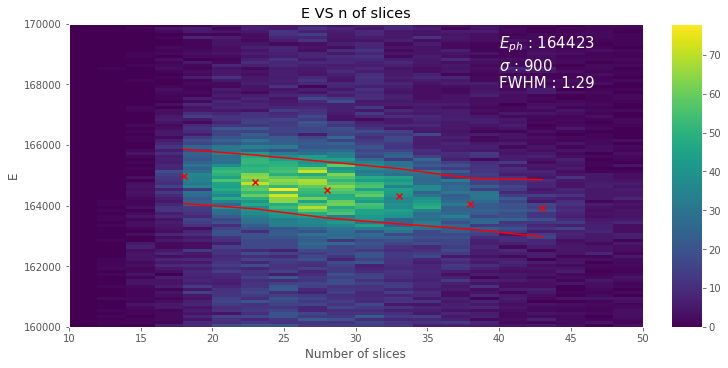

In [22]:
fig_enslices = plt.figure(constrained_layout=True)

gs_enslices = gridspec.GridSpec(1, 1, figure=fig_enslices)

ax_enslices = fig_enslices.add_subplot(gs_enslices[0, 0])
hist_enslices = ax_enslices.hist2d(edf['nslices'], edf['e'] , bins=[.2*nbins, nbins], range=((10, 50),(Emin, Emax)));
ax_enslices.set_xlabel('Number of slices');
ax_enslices.set_ylabel('E');
ax_enslices.set_title('E VS n of slices');
cbar_enslices = fig_enslices.colorbar(hist_enslices[3], ax = ax_enslices)

ax_enslices.scatter(profile['nslices'], profile['Eph'], marker='x', color='r');

ax_enslices.plot(profile['nslices'], profile['Eph'] + profile['sig'], color='r');
ax_enslices.plot(profile['nslices'], profile['Eph'] - profile['sig'], color='r');


Eph = profile['Eph'].mean()
sig = profile['sig'].mean()
t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2))) 

ax_enslices.text(40, 168e3, s = t, fontsize = 15, color='white');

In [23]:
profile

,nslices,Eph,sig,chisq
0,18.0,164963.127150,895.946148,1.733579
1,23.0,164778.331958,887.073524,1.124138
2,28.0,164517.424548,926.811369,1.082704
3,33.0,164308.341103,912.098585,0.762890
4,38.0,164060.599191,839.539656,1.108860
5,43.0,163915.020617,941.608864,1.084431


In [24]:
Eph = profile['Eph'].mean()
sig = profile['sig'].mean()

In [25]:
print('Extrapolated FWHM:', sig/Eph * 235 * (662/2458)**.5)

Extrapolated FWHM: 0.6679304083423556


## 2.5. Fiducial cuts

### 2.5.1. Fit

In [26]:
R_fid = 160
z_fid_max = 550
z_fid_min = 50

In [27]:
fid_edf = edf[(edf.x0**2 + edf.y0**2 < R_fid**2) & (edf.z0 < z_fid_max) & (edf.z0 > z_fid_min)]

In [28]:
ydata, xdata = np.histogram(fid_edf['e'], bins=nbins, range=(Emin, Emax))
xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

guess = [np.mean(fid_edf['e']), np.std(fid_edf['e']), np.max(ydata), -1, np.mean(ydata)]
popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata))

Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]

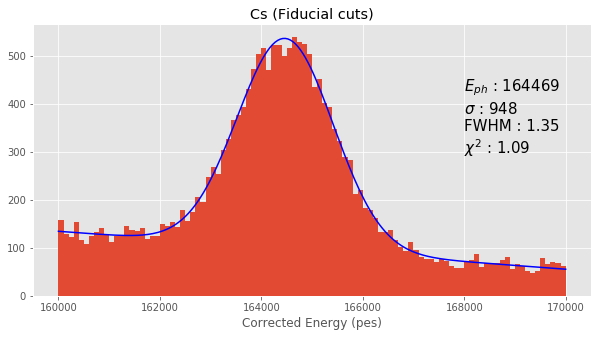

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(fid_edf['e'], bins=nbins);
E = np.linspace(Emin, Emax, 2*nbins);
ax.plot(E, F(E, *popt), color = 'b');

t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2)) + 
     "\n" + r"$\chi^2$ : {}".format(round(chisq(F, popt, xdata, ydata),2))) 

ax.text(168000, 300, s = t, fontsize = 15);
ax.set_xlabel('Corrected Energy (pes)');
ax.set_title('{} (Fiducial cuts)'.format(typo));

In [30]:
print('Extrapolated FWHM:',sig/Eph * 235 * (662/2458)**.5)

Extrapolated FWHM: 0.7029902773804488


### 2.5.2. Number of slices profile

In [31]:
## Profile construction
cut    = 100 #cut for the number of entries in each slice
n_merg = 5   #size of the group of slices to merge

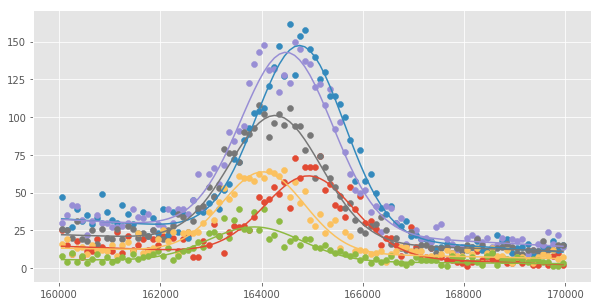

In [32]:
nslices_raw = np.unique(fid_edf['nslices'])

#Cut in number of slices
nslices = []
for nsl in nslices_raw:
    if len(edf[edf.nslices == nsl])<cut:
        continue
    else: nslices.append(nsl)
nslices = np.array(nslices)

nslices_merged = np.array([nslices[n_merg*i:n_merg*(i+1)] for i in range(0, int(len(nslices)/n_merg))])

profile = pd.DataFrame(columns=['nslices', 'Eph', 'sig', 'chisq'])
for nslices in nslices_merged:
    cdf = fid_edf[(fid_edf.nslices >= nslices[0]) & ((fid_edf.nslices <= nslices[-1]))]
    
    #Fitting
    ydata, xdata = np.histogram(cdf['e'], bins=nbins, range = (Emin,Emax))
    xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

    guess = [np.mean(cdf['e']), np.std(cdf['e']), np.max(ydata), -1, np.mean(ydata)]
    popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata))
    chi = chisq(F, popt, xdata, ydata)
    
    Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]
    
    nsl = np.sum(nslices)/len(nslices)
    profile = profile.append({'nslices': nsl, 'Eph': Eph, 'sig': sig, 'chisq': chi}, ignore_index=True)
    
    plt.scatter(xdata, ydata)
    plt.plot(xdata, F(xdata, *popt))

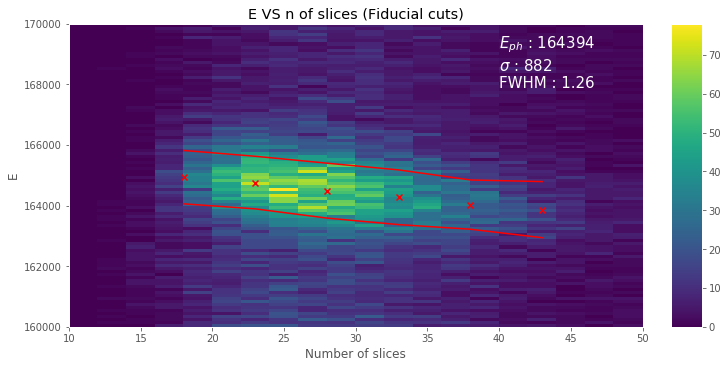

In [33]:
fig_enslices = plt.figure(constrained_layout=True)

gs_enslices = gridspec.GridSpec(1, 1, figure=fig_enslices)

ax_enslices = fig_enslices.add_subplot(gs_enslices[0, 0])
hist_enslices = ax_enslices.hist2d(edf['nslices'], edf['e'] , bins=[.2*nbins, nbins], range=((10, 50),(Emin, Emax)));
ax_enslices.set_xlabel('Number of slices');
ax_enslices.set_ylabel('E');
ax_enslices.set_title('E VS n of slices (Fiducial cuts)');
cbar_enslices = fig_e.colorbar(hist_enslices[3], ax = ax_enslices)

ax_enslices.scatter(profile['nslices'], profile['Eph'], marker='x', color='r');

ax_enslices.plot(profile['nslices'], profile['Eph'] + profile['sig'], color='r');
ax_enslices.plot(profile['nslices'], profile['Eph'] - profile['sig'], color='r');


Eph = profile['Eph'].mean()
sig = profile['sig'].mean()
t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2))) 

ax_enslices.text(40, 168e3, s = t, fontsize = 15, color='white');

In [34]:
Eph = profile['Eph'].mean()
sig = profile['sig'].mean()

In [35]:
print('Extrapolated FWHM:', sig/Eph * 235 * (662/2458)**.5)

Extrapolated FWHM: 0.6548901864072408


*------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------*

# 3. CHARGE

## 3.1. Overview

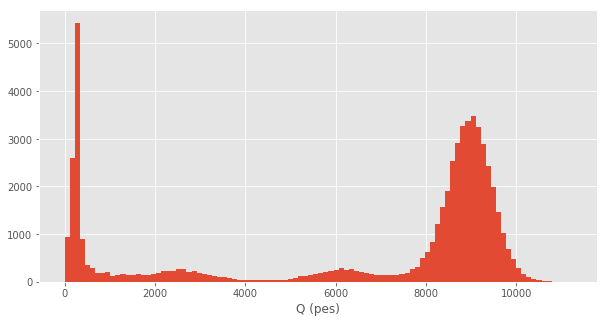

In [36]:
df['q'].hist(bins=nbins);
plt.xlabel('Q (pes)', fontsize=12);

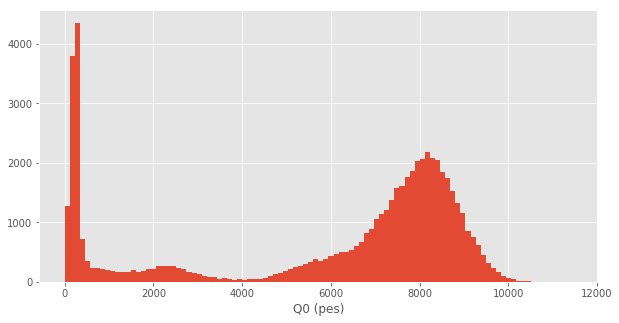

In [37]:
df['q0'].hist(bins=nbins);
plt.xlabel('Q0 (pes)', fontsize=12);

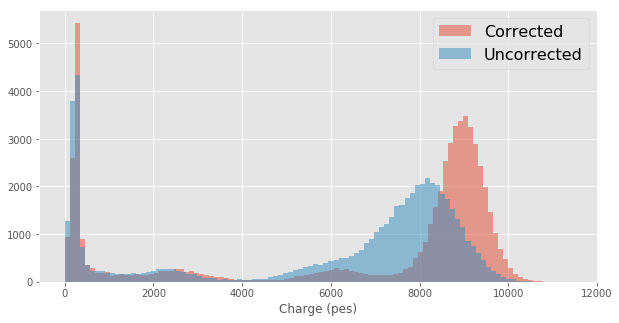

In [38]:
plt.hist(df['q'] , bins = nbins, alpha=.5, label='Corrected' );
plt.hist(df['q0'], bins = nbins, alpha=.5, label='Uncorrected' );
plt.legend(fontsize = 16);
plt.xlabel('Charge (pes)', fontsize=12);

## 3.2. Select region

In [39]:
Qmax = 11e3
Qmin = 7e3

In [40]:
qdf = df[(df.q<Qmax) & (df.q>Qmin)]

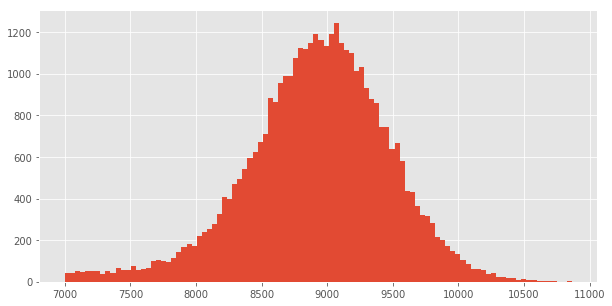

In [41]:
plt.hist(qdf['q'], bins=nbins);

## 3.3. Searching correlations

### 3.3.1. Corrected Charge correlations (Q vs All variables)

In [42]:
var = qdf.keys()
var = var[3:len(var)]
var

Index(['nslices', 'nhits', 'noqslices', 'noqhits', 'time', 's1e', 't0', 'rmax',
       'zmin', 'zmax', 'x0', 'y0', 'z0', 'q0', 'e0', 'x', 'y', 'z', 'q', 'e'],
      dtype='object')

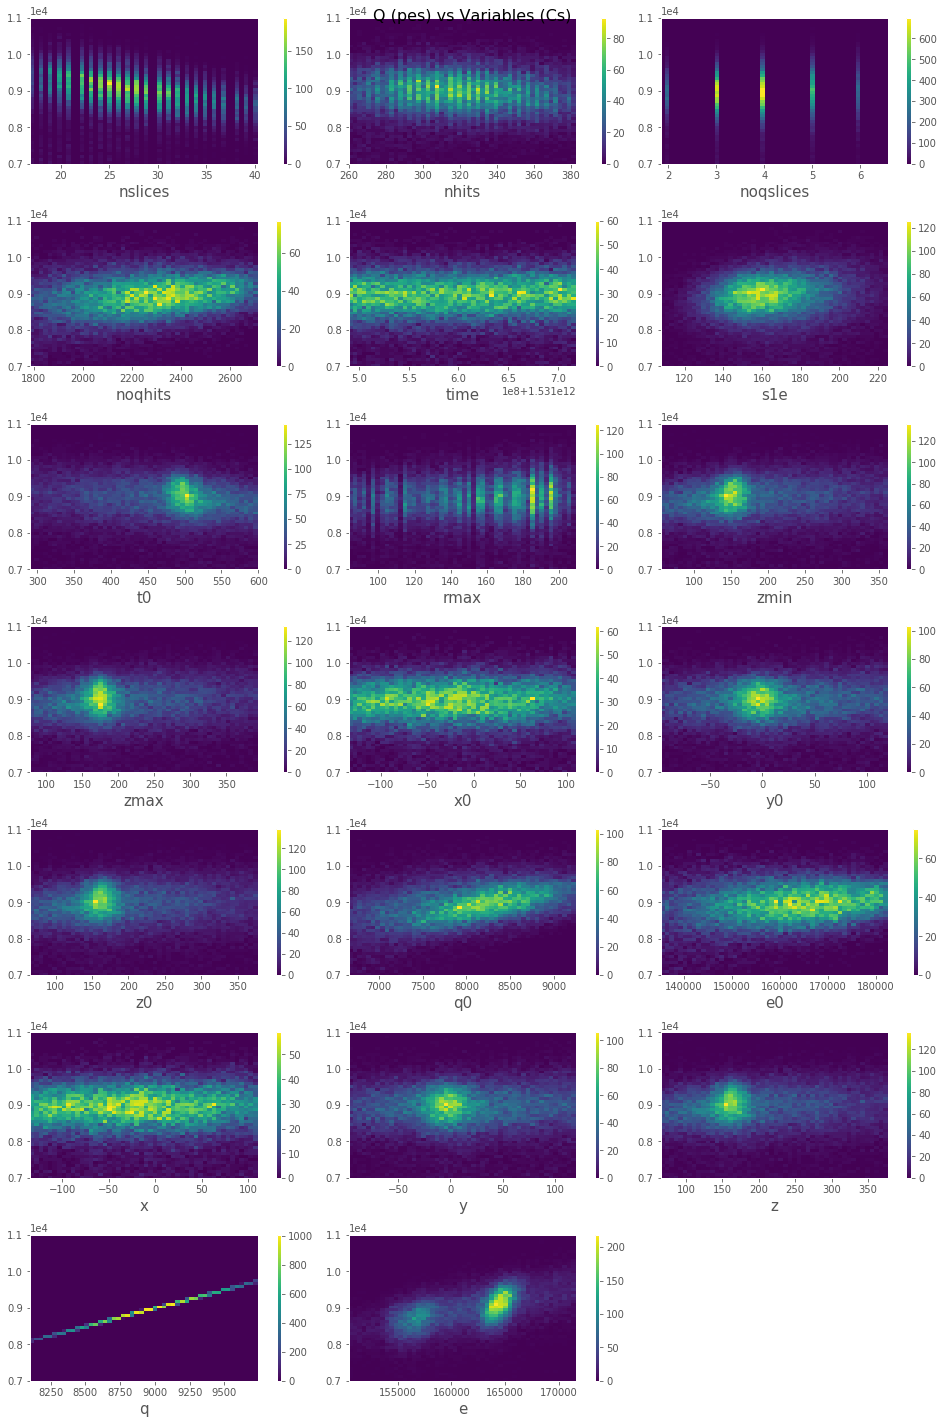

In [43]:
fig_q = plt.figure(figsize =[13, 20], constrained_layout=True);

gs_q = gridspec.GridSpec(round(len(var)/3+.5), 3, figure=fig_q);

i=0
for v in var:
    axes    = f'ax_q{v}   = fig_q.add_subplot(gs_q[{i}])'
    exec(axes)
    hist       = (f'hist_q{v} = ax_q{v}.hist2d(qdf["{v}"], qdf["q"] ,bins=.5*nbins,' + 
                  f'range=((np.mean(qdf["{v}"])-1.5*np.std(qdf["{v}"]), np.mean(qdf["{v}"])+1.5*np.std(qdf["{v}"])), (Qmin, Qmax)))')
    exec(hist)
    labels     = (f'ax_q{v}.set_xlabel("{v}", fontsize=15) \n'+
                  f'ax_q{v}.ticklabel_format(style="sci", axis="y", scilimits=(0,0))')
    exec(labels)
    i+=1

for v in var:
    cbars      = f'cbar_q{v} = fig_q.colorbar(hist_q{v}[3], ax = ax_q{v})'
    exec(cbars)
fig_q.suptitle(f'Q (pes) vs Variables ({typo})', fontsize=16);

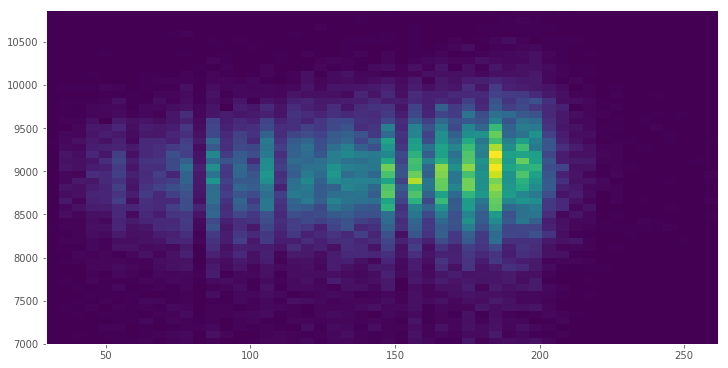

In [44]:
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0])

ax.hist2d(qdf['rmax'], qdf['q'], bins=.5*nbins);

### 3.4.2 Q vs Number of Slices

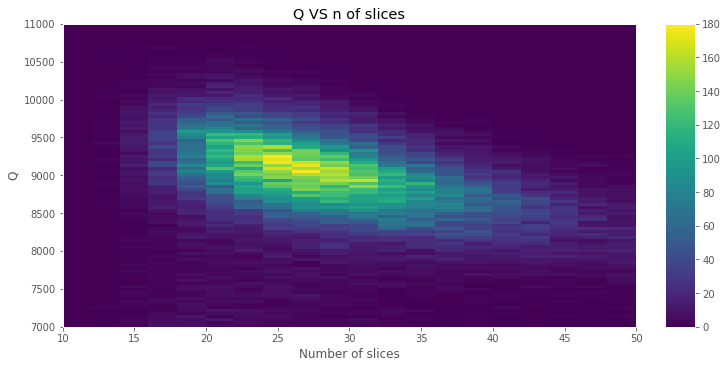

In [45]:
fig_qnslices = plt.figure(constrained_layout=True)

gs_qnslices = gridspec.GridSpec(1, 1, figure=fig_qnslices)

ax_qnslices = fig_qnslices.add_subplot(gs_qnslices[0, 0])
hist_qnslices = ax_qnslices.hist2d(qdf['nslices'], qdf['q'] , bins=[.2*nbins, nbins], range=((10, 50),(Qmin, Qmax)));
ax_qnslices.set_xlabel('Number of slices');
ax_qnslices.set_ylabel('Q');
ax_qnslices.set_title('Q VS n of slices');
cbar_qnslices = fig_qnslices.colorbar(hist_qnslices[3], ax = ax_qnslices)

## 3.5. Fiducial cuts

### 3.5.1. Q vs Number of slices

In [46]:
R_fid = 160
z_fid_max = 550
z_fid_min = 50

In [47]:
fid_qdf = qdf[(qdf.x0**2 + qdf.y0**2 < R_fid**2) & (qdf.z0 < z_fid_max) & (qdf.z0 > z_fid_min)]

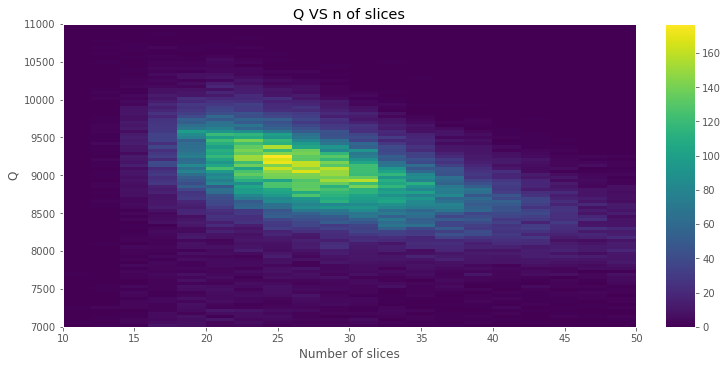

In [48]:
fig_qnslices = plt.figure(constrained_layout=True)

gs_qnslices = gridspec.GridSpec(1, 1, figure=fig_qnslices)

ax_qnslices = fig_qnslices.add_subplot(gs_qnslices[0, 0])
hist_qnslices = ax_qnslices.hist2d(fid_qdf['nslices'], fid_qdf['q'] , bins=[.2*nbins, nbins], range=((10, 50),(Qmin, Qmax)));
ax_qnslices.set_xlabel('Number of slices');
ax_qnslices.set_ylabel('Q');
ax_qnslices.set_title('Q VS n of slices');
cbar_qnslices = fig_qnslices.colorbar(hist_qnslices[3], ax = ax_qnslices)

*------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------*

# 4. Energy/Charge

## 4.1. Photopeak selection and histogram

In [46]:
Emax = 170e3
Emin = 160e3

Qmin = 7e3
Qmax = 11e3

eqdf = df[(df.e<Emax)&(df.e>Emin)&(df.q<Qmax)&(df.q>Qmin)]

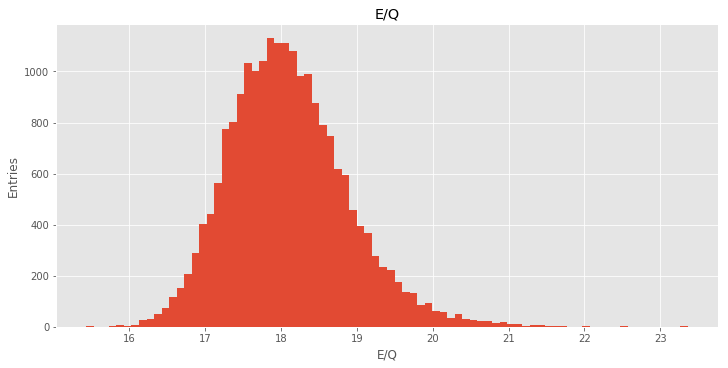

In [47]:
fig_eq = plt.figure(constrained_layout=True)

gs_eq = gridspec.GridSpec(1, 1, figure=fig_eq)

ax_hist = fig_eq.add_subplot(gs_eq[0])
hist_eq = ax_hist.hist(eqdf['e']/eqdf['q'], bins=int(.8*nbins));
ax_hist.set_xlabel('E/Q');
ax_hist.set_ylabel('Entries');
ax_hist.set_title('E/Q');

## 4.2. Correlations (E/Q vs all variables)

In [48]:
var = eqdf.keys()
var = var[3:len(var)]
var

Index(['nslices', 'nhits', 'noqslices', 'noqhits', 'time', 's1e', 't0', 'rmax',
       'zmin', 'zmax', 'x0', 'y0', 'z0', 'q0', 'e0', 'x', 'y', 'z', 'q', 'e'],
      dtype='object')

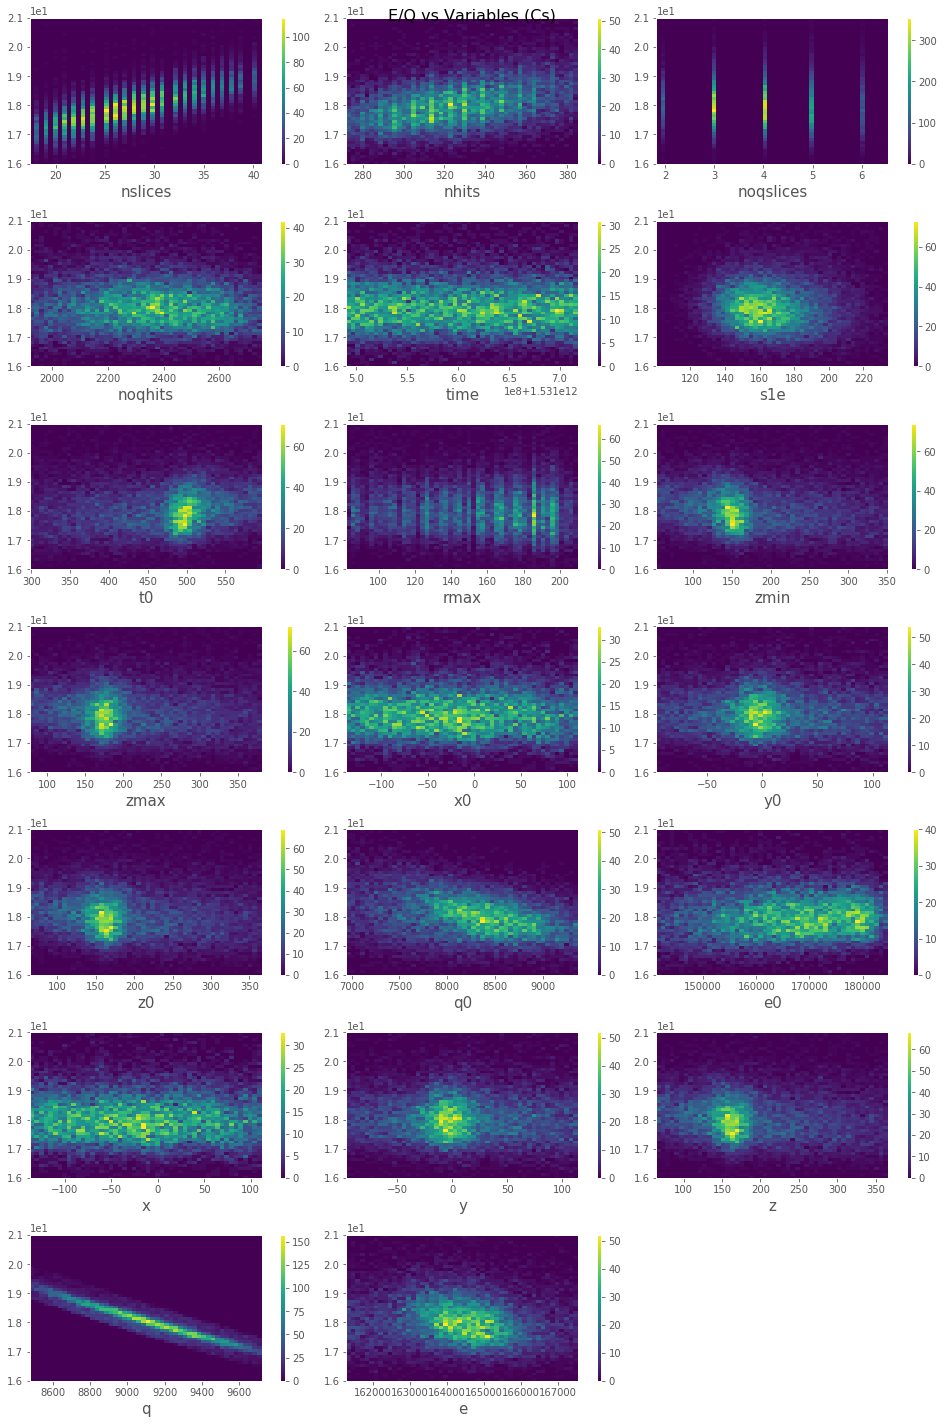

In [49]:
fig_eq = plt.figure(figsize =[13, 20], constrained_layout=True);

gs_eq = gridspec.GridSpec(round(len(var)/3+.5), 3, figure=fig_eq);

i=0
for v in var:
    axes    = f'ax_eq{v}   = fig_eq.add_subplot(gs_eq[{i}])'
    exec(axes)
    hist       = (f'hist_eq{v} = ax_eq{v}.hist2d(eqdf["{v}"], eqdf["e"]/eqdf["q"] ,bins=.5*nbins,' +
                  f'range=((np.mean(eqdf["{v}"])-1.5*np.std(eqdf["{v}"]), np.mean(eqdf["{v}"])+1.5*np.std(eqdf["{v}"])), (16, 21)))')
    exec(hist)
    labels     = (f'ax_eq{v}.set_xlabel("{v}", fontsize=15) \n'+
                  f'ax_eq{v}.ticklabel_format(style="sci", axis="y", scilimits=(0,0))')
    exec(labels)
    i+=1

for v in var:
    cbars      = f'cbar_eq{v} = fig_eq.colorbar(hist_eq{v}[3], ax = ax_eq{v})'
    exec(cbars)
fig_eq.suptitle(f'E/Q vs Variables ({typo})', fontsize=16);

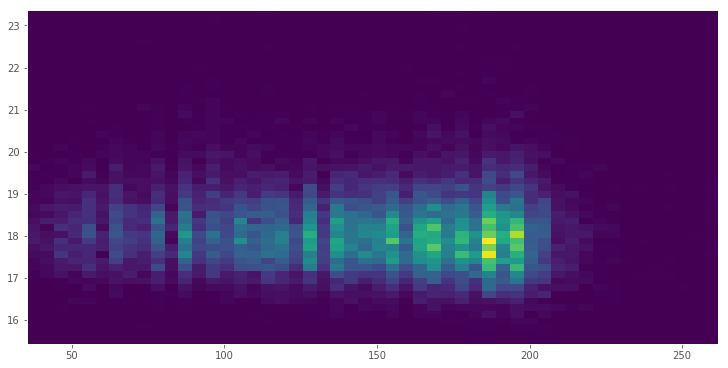

In [50]:
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0])

ax.hist2d(eqdf['rmax'], eqdf['e']/eqdf['q'], bins=.5*nbins);

### 3.4.2 E/Q vs Number of Slices, Energy and Charge 

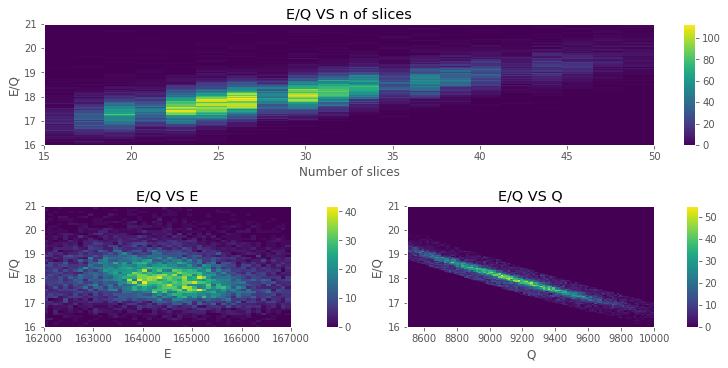

In [57]:
fig_eqc = plt.figure(constrained_layout=True)

gs_eqc = gridspec.GridSpec(2, 2, figure=fig_eqc)

ax_eqnsl = fig_eqc.add_subplot(gs_eqc[0, 0:2])
hist_eqnsl = ax_eqnsl.hist2d(eqdf['nslices'], eqdf['e']/eqdf['q'], bins=[.2*nbins, nbins], 
                                    range=((15, 50),(16, 21)));
ax_eqnsl.set_xlabel('Number of slices');
ax_eqnsl.set_ylabel('E/Q');
ax_eqnsl.set_title('E/Q VS n of slices');
cbar_eqnsl = fig_eqc.colorbar(hist_eqnsl[3], ax = ax_eqnsl)

ax_eqe = fig_eqc.add_subplot(gs_eqc[1, 0])
hist_eqe = ax_eqe.hist2d(eqdf['e'], eqdf['e']/eqdf['q'], bins=[.5*nbins, .5*nbins], 
                                    range=((162e3, 167e3),(16, 21)));
ax_eqe.set_xlabel('E');
ax_eqe.set_ylabel('E/Q');
ax_eqe.set_title('E/Q VS E');
cbar_eqe = fig_eqc.colorbar(hist_eqe[3], ax = ax_eqe)

ax_eqq = fig_eqc.add_subplot(gs_eqc[1, 1])
hist_eqq = ax_eqq.hist2d(eqdf['q'], eqdf['e']/eqdf['q'], bins=[nbins, nbins], 
                                    range=((8.5e3, 10e3),(16, 21)));
ax_eqq.set_xlabel('Q');
ax_eqq.set_ylabel('E/Q');
ax_eqq.set_title('E/Q VS Q');
cbar_eqq = fig_eqc.colorbar(hist_eqq[3], ax = ax_eqq)

## 3.5. Fiducial cuts

### 3.5.1. Q vs Number of slices

In [56]:
R_fid = 160
z_fid_max = 550
z_fid_min = 50

In [57]:
fid_eqdf = eqdf[(eqdf.x0**2 + eqdf.y0**2 < R_fid**2) & (eqdf.z0 < z_fid_max) & (eqdf.z0 > z_fid_min)]

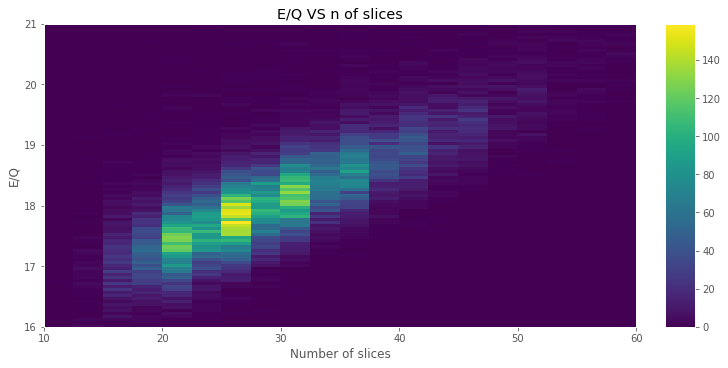

In [58]:
fig_eqnslices = plt.figure(constrained_layout=True)

gs_eqnslices = gridspec.GridSpec(1, 1, figure=fig_eqnslices)

ax_eqnslices = fig_eqnslices.add_subplot(gs_eqnslices[0, 0])
hist_eqnslices = ax_eqnslices.hist2d(fid_eqdf['nslices'], fid_eqdf['e']/fid_eqdf['q'] , bins=[.2*nbins, nbins],
                                     range=((10, 60),(16, 21)));
ax_eqnslices.set_xlabel('Number of slices');
ax_eqnslices.set_ylabel('E/Q');
ax_eqnslices.set_title('E/Q VS n of slices');
cbar_eqnslices = fig_eqnslices.colorbar(hist_eqnslices[3], ax = ax_eqnslices)